# Advanced QAOA parameter classes

Here we illustrate the use of the `Annealing` and `Fourier` parameter classes included in the EntropicaQAOA. We also show how to obtain constraints on parameters in the `ExtendedParams` class, which may be useful for using certain classical optimisers within QAOA.

## Contents

1. [The `Annealing` parameter class](#annealing)
2. [The `Fourier` parameter class](#fourier)
3. [Parameter constraints with `ExtendedParams`](#constraint)

In [1]:
# import the standard modules from python
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# import the neccesary pyquil modules
from pyquil.api import local_qvm, WavefunctionSimulator
from pyquil.paulis import PauliSum, PauliTerm
from pyquil.unitary_tools import lifted_pauli

# import the QAOAParameters classes 
from entropica_qaoa.qaoa.parameters import (AbstractParams, AnnealingParams, StandardParams, 
                                            FourierParams, ExtendedParams)
from entropica_qaoa.qaoa.cost_function import QAOACostFunctionOnWFSim
from entropica_qaoa.utilities import *

# turn off matplotlib warnings associated with networkx
import warnings
warnings.filterwarnings("ignore")

# Set up the WavefunctionSimulator object
sim = WavefunctionSimulator()

<a id='annealing'></a>

## The `Annealing` parameter class

In quantum annealing, we start in the ground state of a _mixer_ (or _reference_) Hamiltonian $H_M$, and gradually transform to the ground state of a _cost_ Hamiltonian $H_C$, according to some annealing schedule function $s(t)$, where $t$ denotes time. If it were possible to perform the transformation infintessimally slowly, we would be guaranteed to arrive at the exact ground state of the cost Hamiltonian. In practice, the transformation is performed over some finite time, and we hope to prepare the ground state of $H_C$ with some acceptably high probability.

At any time $t$ during the procedure, the instantaneous Hamiltonian is given by

\begin{equation}
H(t) = \left(1 - s(t)\right)H_M + s(t)H_C
\end{equation}

where $s(0) = 0$, and $s(t = T) = 1$, and $T$ is the total annealing time. We see that the strengths with which $H_M$ and $H_C$ act at a given time are related: the mixer is applied with a weight $(1 - s(t))$, and the cost Hamiltonian with weight $s(t)$. It is common to view the QAOA as a form of discretised annealing, where the procedure is performed in a fixed number of steps $p$. However, the coefficients of the mixer and cost Hamiltonians need not be related in the simple way that they are in a conventional annealing schedule. 

The `AnnealingParams` parameter class illustrates what is perhaps the first conceptual step from annealing, towards the more conventionally used parametrisations of QAOA. Using `AnnealingParams`, we prepare an output quantum state with a circuit described by the unitary operator

\begin{equation}
U = \exp\left(-i(1-s(t_p)) H_M \Delta t\right)\exp\left(-i s(t_p) H_C \Delta t\right) \cdots \exp\left(-i(1-s(t_1))H_M \Delta t\right) \exp\left(-i s(t_1) H_C \Delta t\right)
\end{equation}

Here, we have a fixed temporal step of size $\Delta t$, and we need to specify what the values of the annealing schedule function should be at the different timesteps. That is, we need to provide a list of the values of $s(t_i$) for $i = 1,..,p$.

Here we illustrate the use of the `AnnealingParams` class, whose value we envisage primarily as a didactic or research tool. Specifically, let's compare the annealing parametrisation with the `StandardParams` parametrisation.

First, we set up the Hamiltonian as usual.

In [2]:
# Create a hamiltonian on 3 qubits with 2 coupling terms and 1 bias term
Term1 = PauliTerm("Z", 0, 0.7)*PauliTerm("Z", 1)
Term2 = PauliTerm("Z", 0, 1.2)*PauliTerm("Z", 2)
Term3 = PauliTerm("Z", 0, -0.5)

hamiltonian = PauliSum([Term1,Term2,Term3])
print("hamiltonian =", hamiltonian)

hamiltonian = (0.7+0j)*Z0*Z1 + (1.2+0j)*Z0*Z2 + (-0.5+0j)*Z0


We'll use the `linear_ramp_from_hamiltonian` method to determine the values of the function $s$ at the different timesteps.

In [3]:
p = 5
linear_annealing_params = AnnealingParams.linear_ramp_from_hamiltonian(hamiltonian, p)
print(linear_annealing_params)

Hyperparameters:
	register: [0, 1, 2]
	qubits_singles: [0]
	qubits_pairs: [[0, 1], [0, 2]]
Parameters:
	schedule: [0.1 0.3 0.5 0.7 0.9]


Now let's optimise the cost function and examine the corresponing output parameters.

expectation value =  -1.9930051867998464


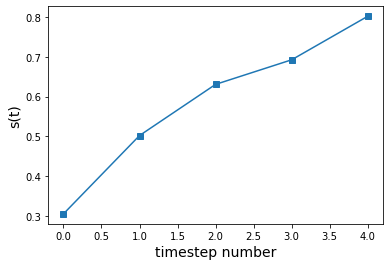

In [4]:
# set up the cost function
cost_anneal = QAOACostFunctionOnWFSim(hamiltonian,
                                      params=linear_annealing_params,)

# and optimize the parameters
res_anneal = minimize(cost_anneal, linear_annealing_params.raw(), method="Cobyla")

print("expectation value = ", res_anneal.fun)

linear_annealing_params.update_from_raw(res_anneal.x)
linear_annealing_params.plot()

Now let's solve the same problem using `StandardParams`.

expectation value =  -2.2897466431591567


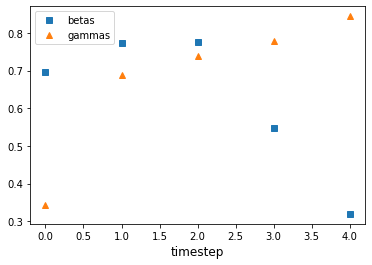

In [5]:
standard_params = StandardParams.linear_ramp_from_hamiltonian(hamiltonian,p)

cost_standard = QAOACostFunctionOnWFSim(hamiltonian,
                                        params=standard_params)

res_std = minimize(cost_standard, standard_params.raw(), method="Cobyla")

print("expectation value = ", res_std.fun)
standard_params.update_from_raw(res_std.x)
standard_params.plot()

Observe that, at least for this simple problem, the expectation values obtained are reasonably similar, yet we use half the number of parameters in `AnnealingParams` as `StandardParams`.

In the optimal `StandardParams`, we see a general downward (upward) trend in the betas (gammas), which is conistent with the annealing picture that the mixer Hamiltonian is gradually turned off, and the cost Hamiltonian is gradually turned on. 

Following [Ref 1](#references), we can attempt to make a connection between the two pictures, by interpreting the sum of all the `betas` and `gammas` as a total annealing time. We can then define the corresponding annealing schedule function value at each time as

\begin{equation}
s(t_i) = \frac{|\gamma_i|}{|\beta_i| + |\gamma_i|}
\end{equation}

When we plot this function, we see a similar behaviour to that of the optimal annealing schedule we found above.

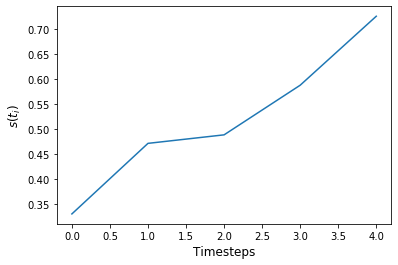

In [6]:
opt_betas = standard_params.betas
opt_gammas = standard_params.gammas
hybrid_params = [np.abs(opt_gammas[i])/(np.abs(opt_gammas[i]) + np.abs(opt_betas[i])) for i in range(p)]

plt.plot(range(p),hybrid_params)
plt.xlabel('Timesteps', fontsize=12)
plt.ylabel('$s(t_i)$', fontsize=12)
plt.show()

<a id='fourier'></a>
## The `Fourier` parameter class

This parameter class originated from attempts to find heuristic ways of reducing the number of parameters required to perform QAOA. Based on empirical observations in patterns of the optimal QAOA angles, Zhuo et al (see [Ref 1](#references)) proposed considering the discrete Fourier transforms of `betas` and `gammas` as an alternative, more economical parametrisation.

The basic idea kicks off from  the conventional QAOA parametrisation, i.e. what we call the `StandardParams` class. Here, at each iteration in QAOA we have one angle for all of the mixer Hamiltonian terms, and one angle for all of the cost Hamiltonian terms. That is, the `StandardParams` parametrisation requires the specification of $2p$ numbers, a `beta` and a `gamma` for each timestep.

In the Fourier representation, we switch instead to a set of $2q$ parameters, denoted $\vec{v}$ and $\vec{u}$, which are related to $\vec{\beta}$ and $\vec{\gamma}$ by

\begin{eqnarray}
\beta_i^{(p)} &=& \sum_{k=1}^q v_k \cos\left[(2k+1)\left(\frac{\pi}{2p}i\right)\right]\\
\gamma_i^{(p)} &=& \sum_{k=1}^q u_k \sin\left[(2k+1)\left(\frac{\pi}{2p}i\right)\right]
\end{eqnarray}

where $i = 1,...,p$. The insight of Zhou et al is that the optimal parameters found are often empirically seen to be smoothly varying functions for certain problems (such as the one in the section above on annealing), and that it should then be possible to use a reduced parameter set consisting of only the lowest $q$ frequency components of those functions. Clearly, for $q\geq p$ we have the full expressivity of the original parameter set (i.e. the $\beta$s and $\gamma$s). In this parametrisation, for fixed $q$, the optimisation problem therefore becomes that of finding the optimal Fourier components $v_k$ and $u_k$. 

In [Ref 1](#references), the authors show that certain variants of this basic Fourier parametrisation can perform significantly better than a  randomised brute force search through parameter space, for MaxCut problems on 3-regular and 4-regular graphs. Here, we will compare `FourierParams` and `StandardParams` for different instances of a relatively small problem. 

We will consider 3-regular graphs on 8 nodes, and use the `linear_ramp_from_hamiltonian` method to generate intial parameters for each of the two classes. We generate a random problem instance, and find the optimial ground state energy returned using the two parametrisations. We then compute the relative error of each from the true ground state energy. 

First we define a convenience function for the following computations:

In [7]:
def randgraph_fourier_std(degree, nodes, p_fourier, q, p_standard):
    
    """
    Produce a k-regular graph on the specified number of nodes, where k is given by the input variable 'degree'.
    The graph edges are random and weighted.
    
    Runs QAOA on the graph using:
     - FourierParams with the specified number of steps p_fourier and frequency components p.
     - StandardParams with number of steps p_standard.
     
    Returns the optimal cost function values obtained by each method, as well as its exact minimum value 
    (found by diagonalising the Hamiltonian).
    """
    
    # Generate a random graph
    graph = random_k_regular_graph(degree, range(nodes), weighted=True)
    hamiltonian = hamiltonian_from_graph(graph)
    
    # Get ground state energy
    hamiltonian_matrix = lifted_pauli(hamiltonian, hamiltonian.get_qubits())
    ground_energy = min(np.linalg.eigvals(hamiltonian_matrix))
    
    # Define Fourier params and run optimisation
    fourier_params = FourierParams.linear_ramp_from_hamiltonian(hamiltonian, p_fourier, q)
    cost_fourier = QAOACostFunctionOnWFSim(hamiltonian, params=fourier_params, sim=sim)
    res_fourier = minimize(cost_fourier, fourier_params.raw())
    
    # Define Standard params and run optimisation
    std_params = StandardParams.linear_ramp_from_hamiltonian(hamiltonian, p_standard)
    cost_std = QAOACostFunctionOnWFSim(hamiltonian, params=std_params, sim=sim)
    res_std = minimize(cost_std, std_params.raw())
    
    return res_fourier, res_std, ground_energy, hamiltonian

We'll start by setting $p=q$, where in principle the `FourierParams` and the `StandardParams` have equal expressivity. For convenience, we will show the results from only one randomly generated sample graph. However, we would encourage users to run the code for a larger number of samples, with different graph degrees, to investigate the applicability of the conclusions more generally.

In [8]:
p_fourier = 3
p_standard = 3
q = 3

samples = 1 # E.g., with samples = 20, this cell should take around 5 minutes to run on a standard laptop.

err_fourier = np.zeros(samples)
err_std = np.zeros(samples)

for i in range(samples):
    
    res_fourier, res_std, ground_energy, _ = randgraph_fourier_std(3, 8, p_fourier, q, p_standard)

    # Compute relative error 
    err_fourier[i] = np.absolute((res_fourier.fun - ground_energy)/ground_energy)
    err_std[i] = np.absolute((res_std.fun - ground_energy)/ground_energy)
    
print("Mean error using FourierParams: ", np.mean(err_fourier))
print("Mean error using StandardParams: ", np.mean(err_std))

Mean error using FourierParams:  0.20777094493836892
Mean error using StandardParams:  0.20777094493845918


As expected for the case $q=p$ - where `StandardParams` and `FourierParams` have identical expressivity - we find that the two methods give very similar results. To begin to appreciate the benefits of the Fourier parametrisation, let's compare the case $p=2$ using `StandardParams` with the case $q = 2, p=3$ using `FourierParams`. Here, we are optimising over the same total number of parameters, however the `FourierParams` ought to be capturing features of a more expressive circuit. 

In [9]:
p_fourier = 3
p_standard = 2
q = 2

samples = 1 

err_fourier = np.zeros(samples)
err_std = np.zeros(samples)

for i in range(samples):
    
    res_fourier, res_std, ground_energy, _ = randgraph_fourier_std(3, 8, p_fourier, q, p_standard)

    # Compute relative error 
    err_fourier[i] = np.absolute((res_fourier.fun - ground_energy)/ground_energy)
    err_std[i] = np.absolute((res_std.fun - ground_energy)/ground_energy)
    
print("Mean error using FourierParams: ", np.mean(err_fourier))
print("Mean error using StandardParams: ", np.mean(err_std))

Mean error using FourierParams:  0.2503669415559566
Mean error using StandardParams:  0.32173134132200654


We see that the Fourier parametrisation returns a more accurate cost function value. Let's go one step further and try the case $p=1$ with `StandardParams`, and $q = 1, p=3$ with `FourierParams`.

In [10]:
p_fourier = 3
p_standard = 1
q = 1

samples = 1 

err_fourier = np.zeros(samples)
err_std = np.zeros(samples)

for i in range(samples):
    
    res_fourier, res_std, ground_energy, _ = randgraph_fourier_std(3, 8, p_fourier, q, p_standard)

    # Compute relative error 
    err_fourier[i] = np.absolute((res_fourier.fun - ground_energy)/ground_energy)
    err_std[i] = np.absolute((res_std.fun - ground_energy)/ground_energy)
    
print("Mean error using FourierParams: ", np.mean(err_fourier))
print("Mean error using StandardParams: ", np.mean(err_std))

Mean error using FourierParams:  0.23798497045606368
Mean error using StandardParams:  0.4860210471594892


In this case, we find an even greater separation in accuracy between the two methods, as intuitively expected. 

While we have studied only small and relatively simple problems in the above examples, the results suggest that the economy of the `Fourier` parametrisation may be worth further investigation.

<a id='constraints'></a>
## Parameter constraints with `ExtendedParams`

Certain classical optimisers that may be of interest for QAOA require a set of constraints on the parameters to be explicitly specified. To be able to use these methods in practice with QAOA, we therefore need a way of obtaining these constraints. The `get_constraints` method does this for the `ExtendedParams` class.

To understand the origin of constraints on the angles, let us first consider the application of the mixer Hamiltonian. Using `ExtendedParams`, at any given step in the QAOA circuit the action of the mixer is described by the unitary operator

\begin{equation}
U\left(\vec{\beta}\right) = \exp(-i\beta_nX_n)...\exp(-i\beta_2X_2)\exp(-i\beta_1X_1)
\end{equation}

Since the eigenvalues of the $X$ operator are just $\pm 1$, by periodicity we can constrain all of the angles $\beta_1,...,\beta_n$ to the range $[0, 2\pi]$. Similarly, the action of single-qubit bias terms in the cost function Hamiltonian corresponds to an operator of the form

\begin{equation}
U\left(\vec{\gamma_s}\right) = \exp(-i\gamma_{n}h_nZ_n)...\exp(-i\gamma_{2}h_2Z_2)\exp(-i\gamma_{1}h_1Z_1)
\end{equation}

Again, since each term is periodic, the corresponding constraints become $\gamma_{j} \in [0,2\pi/h_j]$, for $j = 1,...,n$. By similar reasoning, the constraints on the coefficients of the qubit pair terms in the Hamiltonian are $\Gamma_{jk} \in [0,2\pi/h_{jk}]$. 

Consider again the Hamiltonian we used in the section on annealing above.

In [11]:
Term1 = PauliTerm("Z", 0, 0.7)*PauliTerm("Z", 1)
Term2 = PauliTerm("Z", 0, 1.2)*PauliTerm("Z", 2)
Term3 = PauliTerm("Z", 0, -0.5)

hamiltonian = PauliSum([Term1,Term2,Term3])
print("hamiltonian =", hamiltonian)

hamiltonian = (0.7+0j)*Z0*Z1 + (1.2+0j)*Z0*Z2 + (-0.5+0j)*Z0


Let's set up a set of `ExtendedParams`.

In [12]:
ext_params = ExtendedParams.empty((hamiltonian,1))

Calling the `get_constraints()` method will now return a single list of the constraints on all of the parameters. The ordering coincides with that of the `raw()` method, allowing both the parameter initial values and the corresponding constraints to be easily passed to the optimiser.

In [13]:
ext_params.get_constraints()

<a id='references'></a>

## References

1. L. Zhou et al, __[*Quantum Approximate Optimization Algorithm: Performance, Mechanism, and Implementation on Near-Term Devices*](https://arxiv.org/abs/1812.01041)__